In [115]:
%load_ext autoreload
%autoreload 2

%matplotlib inline


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import seaborn as sns

sns.set_style('darkgrid',{'axes.spines.bottom': True,
             'axes.spines.left': True,
             'axes.spines.right': True,
             'axes.spines.top': True,
             'axes.edgecolor':'.0'})

sns.set_context('talk')
sns.set_palette('colorblind')
__name__ = 'main'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [220]:
# export
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import OrderedDict
from scipy.optimize import minimize
from numpy.random import multivariate_normal
from scipy.special import erf
from scipy.integrate import quad
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.stats import chi2


from pathlib import Path
Path.ls = lambda p: [i for i in p.iterdir()]

def pickleLoad(fname):
    with open(fname,'rb') as f:
        return pickle.load(f)

def pickleDump(fname,obj):
    with open(fname,'wb') as f:
        pickle.dump(obj,f,pickle.HIGHEST_PROTOCOL)
    
def toeplitzMATLAB(a,n):
    a_m = a[::-1]
    a_n = a[:n]
    return np.flipud(toeplitz(a_m,a_n))

def fullDisplay(df,max_rows=None,max_col=None,width=None):
    df_cp = df.style.set_properties( **{'width': f'{width}px'}) if width is not None else df.copy() 
    with pd.option_context('display.max_rows', max_rows, 'display.max_columns', max_col,):
        display(df_cp)

r0_str = r'$R_0$'
R0_str = r'$R_0$'
gamma_str = r'$\gamma^{-1}$'
tau_str = r'$\tau$'


In [3]:
# export
from scipy.signal import correlate
from scipy.linalg import toeplitz

# Load data 

In [4]:
#export
JHU_dir = './JHU/COVID-19'
JHU_path = Path(f'./{JHU_dir}/csse_covid_19_data/csse_covid_19_time_series/')
JHU_confirmed_path = Path(f'./{JHU_dir}/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
JHU_death_path = Path(f'./{JHU_dir}/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
JHU_recovered_path = Path(f'./{JHU_dir}/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

JHU_confirmed_df = pd.read_csv(JHU_confirmed_path);    
JHU_death_df = pd.read_csv(JHU_death_path);             
JHU_recovered_df = pd.read_csv(JHU_recovered_path);   

JHU_dfs = {'confirmed':JHU_confirmed_df,'death':JHU_death_df,'recovered':JHU_recovered_df}

NYT_us_cases = pd.read_csv('/opt/genomics/Jupyter_Notebook/NadavRakocz/covid19/NYT_output/time_series_us_cases_NYT.csv')

data = {}

In [5]:
JHU_confirmed_df.sort_values(by='4/24/20',ascending=False)[['Country/Region','4/24/20']]

,Country/Region,4/24/20
225,US,905358
201,Spain,219764
137,Italy,192994
116,France,158636
120,Germany,154999
223,United Kingdom,143464
213,Turkey,104912
133,Iran,88194
187,Russia,68622
62,China,68128


## UK

In [10]:
eng_cases = JHU_confirmed_df[(JHU_confirmed_df['Country/Region']=='United Kingdom') & JHU_confirmed_df['Province/State'].isna()].iloc[:,4:]
eng_death = JHU_death_df[(JHU_death_df['Country/Region']=='United Kingdom') & JHU_confirmed_df['Province/State'].isna()].iloc[:,4:]
eng_rec = JHU_recovered_df[(JHU_recovered_df['Country/Region']=='United Kingdom') & JHU_confirmed_df['Province/State'].isna()].iloc[:,4:]

In [11]:
first_case = np.argmax((eng_cases>0).values)
sDate = eng_cases.columns[first_case]
eng_ndays = pd.date_range(sDate,'03-24-2020',freq='D').shape[0]
eDate = eng_cases.columns[first_case+eng_ndays-1]

eng_cases_arr = eng_cases.iloc[:,first_case:first_case+eng_ndays].values.flatten()
eng_death_arr = eng_death.iloc[:,first_case:first_case+eng_ndays].values.flatten()
eng_rec_arr = eng_rec.iloc[:,first_case:first_case+eng_ndays].values.flatten()

data['UK'] = (eng_cases_arr,'United Kingdom','eng_fit_res.txt',56*1e6,sDate,eDate)

                  

## Spain 

In [12]:
country = 'Spain'
spn_cases = JHU_confirmed_df[(JHU_confirmed_df['Country/Region']==country) & JHU_confirmed_df['Province/State'].isna()].iloc[:,4:]
spn_death = JHU_death_df[(JHU_death_df['Country/Region']==country) & JHU_confirmed_df['Province/State'].isna()].iloc[:,4:]
spn_rec = JHU_recovered_df[(JHU_recovered_df['Country/Region']==country) & JHU_confirmed_df['Province/State'].isna()].iloc[:,4:]

In [13]:
first_case = np.argmax((spn_cases>0).values)
sDate = spn_cases.columns[first_case]
spn_ndays = pd.date_range(sDate,'03-15-2020',freq='D').shape[0]
eDate = spn_cases.columns[first_case+spn_ndays-1]

spn_cases_arr = spn_cases.iloc[:,first_case:first_case+spn_ndays].values.flatten()
spn_death_arr = spn_death.iloc[:,first_case:first_case+spn_ndays].values.flatten()
spn_rec_arr = spn_rec.iloc[:,first_case:first_case+spn_ndays].values.flatten()

data['Spain'] = (spn_cases_arr,'Spain','spn_fit_res.txt',47*1e6,sDate,eDate)
                  

## New York

In [14]:
country='New York'
ny_cases = NYT_us_cases[NYT_us_cases.state=='New York'].iloc[:,1:]

In [15]:
first_case = np.argmax((ny_cases>0).values)
sDate = ny_cases.columns[first_case]
ny_ndays = pd.date_range(sDate,'03-20-2020',freq='D').shape[0]
eDate = ny_cases.columns[first_case+ny_ndays-1]

ny_cases_arr = ny_cases.iloc[:,first_case:first_case+ny_ndays].values.flatten()

data['NY'] = (ny_cases_arr,'New York','ny_fit_res.txt',19.5*1e6,sDate,eDate)
                  
        

## Denemark 

In [36]:
def getData(country,eDate_raw,N,country_name=None):
    
    country_name = country if country_name is None else country_name
    cases = JHU_confirmed_df[(JHU_confirmed_df['Country/Region']==country) & JHU_confirmed_df['Province/State'].isna()].iloc[:,4:]
    first_case = np.argmax((cases>0).values)
    
    sDate = cases.columns[first_case]
    n_ndays = pd.date_range(sDate,eDate_raw,freq='D').shape[0]
    eDate = cases.columns[first_case+n_ndays-1]

    cases_arr = cases.iloc[:,first_case:first_case+n_ndays].values.flatten()

    return (cases_arr,country_name,f'{country}_fit_res.txt',N,sDate,eDate)


In [40]:
data['Denmark'] = getData('Denmark','03-11-2020',5.8*1e6)

## Germany

In [41]:
data['Germany'] = getData('Germany','03-16-2020',83.02*1e6)

## France 

In [44]:
data['France'] = getData('France','03-16-2020',66.99*1e6)

# Fit

## functions 

In [48]:
# export
def findBestShift(train_case,simcases,test_case=None,
                  train_death=None,simdeath=None,test_death=None,
                  testingperiod=7,debug=False,DEATH_REG = 0.1,loss='mse',norm=False):
    
    EPS = 500
    n_sim = len(simcases)
    trainingperiod = len(train_case)
    testingperiod = len(test_case) if test_case is not None else 0
    if train_death is not None: ratio = train_case[-1]/train_death[-1] 
    
    losses = []
    rel_errs = []
    test_rel_errs = []
    smooth_test_rel_errs = []
    alphas = []
    e = np.sum(train_case**2)
    loss_func = tailwMSE if loss=='tail' else MSE if loss=='mse' else ll_prof
    
#     train_case_m = train_case - train_case.mean()
#     simcases_toeplitz = toeplitzMATLAB(simcases,len(train_case))
    

    for i in range(n_sim-trainingperiod-testingperiod):
        y=simcases[i:i+trainingperiod]
        if(not norm):
            alpha=1
        else:
#             alpha = np.sum(y*train_case)/e if np.sum(y)>EPS else 1
            alpha = max(0.3,np.sum(y*train_case)/e)
        alphas.append(alpha)
        loss_case = loss_func(alpha*train_case,y)
        case_rel_err = np.abs((train_case[-1]-y[-1])/train_case[-1])
        
        
        
        
        # adding death fit
        if train_death is not None:
            loss_death = loss_func(train_death,y)
            loss = loss_case/ratio**2 + DEATH_REG*loss_death
        else:
             loss = loss_case
                
        losses.append(loss)
        rel_errs.append(case_rel_err)
        
        # for prediction
        if(test_case is not None):
            delta = y[-1] - train_case[-1]
            smooth_test_pred = simcases[i+trainingperiod +testingperiod -1] - delta
            smooth_test_rel_err = np.abs((test_case[-1]-smooth_test_pred)/test_case[-1])
            
            test_rel_err = np.abs((test_case[-1]-simcases[i+trainingperiod +testingperiod -1])/test_case[-1])
            test_rel_errs.append(test_rel_err)
            smooth_test_rel_errs.append(smooth_test_rel_err)
                   
        
    if(debug):plt.plot(losses)
    best_shift = np.argmin(losses)

    if(test_case is None):
        return (losses[best_shift],best_shift,rel_errs[best_shift],None,None,alphas[best_shift])
    return (losses[best_shift],best_shift,rel_errs[best_shift],test_rel_errs[best_shift],smooth_test_rel_errs[best_shift],alphas[best_shift])


def tailwMSE(true,pred,ws=3,w=10):
    loss = (true-pred)**2
    ones = np.ones(loss.shape)
    ones[-ws:] = w # [1,1,...,100,100,100]
    return loss.T@ones

def MSE(true,pred):
    loss = np.mean((true-pred)**2)
    return loss

def ll_prof(true,pred):
    T = len(pred)
    return (T/2)*np.log(np.mean((true-pred)**2))

## choose simulation dir

In [49]:
sim_dir = Path('r_gamma_sims_nu46/')

sim_files = [f for f in sim_dir.ls() if f.is_file()]
len(sim_files)

## Fit single region 

In [ ]:
x,country,output_file,N,sDate,eDate = data['France']

In [100]:
scores = []
shifts = []
alphas = []
res_mat = np.zeros((len(sim_files),6))
NORM = False
n_zeros = len(x)-5
ds = False


with open(output_file,'w') as f:
    for i,sim_file in enumerate(sim_files):

        c = pd.read_csv(sim_file,index_col=0).values*N
        d = c[::10] if(ds) else c
        d = np.insert(d,0,np.zeros(n_zeros))
        
        gamma = float(sim_file.stem.split('_')[-1])
        r0 = float(sim_file.stem.split('_')[2])
        endDist = float(sim_file.stem.split('_')[4])
        score,shift,_,_,_,alpha = findBestShift(x,d,norm=NORM,loss='LL')
        res_mat[i,:]=[r0,gamma,score,shift,alpha,endDist]
        
        print(score,shift,alpha,r0,gamma,endDist)
        scores.append(score)
        shifts.append(shift)
        alphas.append(alpha)
        
        f.write(f'{sim_file.name},{score},{shift}\n')

res_df = pd.DataFrame(res_mat,columns=[r0_str,gamma_str,'score','shift','alpha','endDist'])

346.30063243918215 2 1 1.0 2.0 1.0
340.3608020459104 3 1 1.0 3.0 1.0
338.2063652170002 4 1 1.0 4.0 1.0
329.3074977576049 4 1 1.0 5.0 1.0
326.6654311917315 5 1 1.0 6.0 1.0
319.36014960786486 5 1 1.0 7.0 1.0
319.03095949334204 6 1 1.0 8.0 1.0
309.9359002899374 6 1 1.0 9.0 1.0
309.01023945190474 6 1 1.0 10.0 43.0
304.0175687452466 7 1 1.0 11.0 45.0
298.2357524259472 7 1 1.0 12.0 47.0
299.84253387098283 7 1 1.0 13.0 50.0
294.71084695606856 8 1 1.0 14.0 52.0
289.7626617696276 8 1 1.0 15.0 54.0
291.5687690394853 8 1 1.0 16.0 57.0
292.0838425019453 9 1 1.0 17.0 60.0
286.65342536324965 9 1 1.0 18.0 63.0
286.76415434575 9 1 1.0 19.0 66.0
291.0754933950413 9 1 1.0 20.0 69.0
290.51429373026934 10 1 1.0 21.0 71.0
288.4067703999697 10 1 1.0 22.0 74.0
289.81746357071097 10 1 1.0 23.0 77.0
293.60648338242584 10 1 1.0 24.0 80.0
295.7844882524879 11 1 1.0 25.0 82.0
294.73268337628036 11 1 1.0 26.0 85.0
295.69822954391134 11 1 1.0 27.0 88.0
298.1357436742572 11 1 1.0 28.0 91.0
301.4341090751455 11 1 1.0

327.09153339348484 16 1 1.2121 54.0 1417.0
327.5271436089843 16 1 1.2121 55.0 1437.0
346.9060457863166 2 1 1.2828 2.0 117.0
341.5475434284634 3 1 1.2828 3.0 225.0
339.1121051654356 3 1 1.2828 4.0 229.0
330.10381966099226 4 1 1.2828 5.0 384.0
328.8894949981622 5 1 1.2828 6.0 397.0
320.2538847779521 5 1 1.2828 7.0 651.0
320.6081986698879 5 1 1.2828 8.0 642.0
311.38850303597764 6 1 1.2828 9.0 672.0
309.04378949597907 6 1 1.2828 10.0 697.0
306.4729985561014 7 1 1.2828 11.0 726.0
299.0794067387453 7 1 1.2828 12.0 1099.0
299.2152370174225 7 1 1.2828 13.0 1116.0
296.97388760346377 8 1 1.2828 14.0 1146.0
290.20553006353225 8 1 1.2828 15.0 1188.0
290.39612715869356 8 1 1.2828 16.0 1220.0
294.155793261932 9 1 1.2828 17.0 1268.0
287.0153895907248 9 1 1.2828 18.0 1313.0
285.4178552415745 9 1 1.2828 19.0 1352.0
288.81686680437355 9 1 1.2828 20.0 1396.0
291.0864523989909 10 1 1.2828 21.0 1435.0
287.5172438469533 10 1 1.2828 22.0 1459.0
287.8181889938205 10 1 1.2828 23.0 1459.0
291.0914494848189 10 1

326.0194940909077 15 1 1.4949 54.0 1366.0
326.5283556243759 16 1 1.4949 55.0 1390.0
347.5713126229276 2 1 1.5657 2.0 247.0
342.80808495266905 3 1 1.5657 3.0 438.0
339.2054783650308 3 1 1.5657 4.0 563.0
331.01091069318596 4 1 1.5657 5.0 713.0
330.77795924523673 4 1 1.5657 6.0 879.0
321.3121347573702 5 1 1.5657 7.0 1124.0
320.56440138575124 5 1 1.5657 8.0 1118.0
313.0694040140009 6 1 1.5657 9.0 1382.0
309.3063447267794 6 1 1.5657 10.0 1405.0
309.14709806464293 7 1 1.5657 11.0 1459.0
300.31527441961396 7 1 1.5657 12.0 1328.0
298.88899563094066 7 1 1.5657 13.0 1386.0
299.616329006057 8 1 1.5657 14.0 1453.0
291.21555718281184 8 1 1.5657 15.0 1347.0
289.6323046543193 8 1 1.5657 16.0 1400.0
293.88762550696356 8 1 1.5657 17.0 1453.0
288.047921280146 9 1 1.5657 18.0 1349.0
284.60830622469734 9 1 1.5657 19.0 1394.0
286.79462863215286 9 1 1.5657 20.0 1449.0
292.2687351056149 10 1 1.5657 21.0 1459.0
287.21187380825944 10 1 1.5657 22.0 1360.0
286.18063521489916 10 1 1.5657 23.0 1408.0
288.706280275

348.2925547074296 2 1 1.8485 2.0 334.0
344.1322826406436 3 1 1.8485 3.0 512.0
339.3492300870674 3 1 1.8485 4.0 727.0
332.01974610127564 4 1 1.8485 5.0 872.0
330.79578907066514 4 1 1.8485 6.0 1189.0
322.51937023017626 5 1 1.8485 7.0 1415.0
320.6403903602989 5 1 1.8485 8.0 1424.0
314.9410615280318 6 1 1.8485 9.0 1359.0
309.797107615834 6 1 1.8485 10.0 1431.0
311.89934816480684 6 1 1.8485 11.0 1396.0
301.9017886785691 7 1 1.8485 12.0 1459.0
298.8841441541142 7 1 1.8485 13.0 1429.0
302.32511365384266 7 1 1.8485 14.0 1459.0
292.7480596580011 8 1 1.8485 15.0 1440.0
289.32906905793544 8 1 1.8485 16.0 1459.0
292.4098755184104 8 1 1.8485 17.0 1430.0
289.69820059190533 9 1 1.8485 18.0 1459.0
284.40770128001674 9 1 1.8485 19.0 1404.0
285.0978667251549 9 1 1.8485 20.0 1459.0
290.0531072112881 9 1 1.8485 21.0 1459.0
287.5327599558397 10 1 1.8485 22.0 1401.0
285.00388756993203 10 1 1.8485 23.0 1451.0
286.527858067654 10 1 1.8485 24.0 1459.0
290.76252457408555 10 1 1.8485 25.0 1459.0
292.568373107861

324.6312785668355 15 1 2.0606 55.0 1459.0
349.0657166565206 2 1 2.1313 2.0 401.0
345.5104279653009 3 1 2.1313 3.0 682.0
339.54328114877393 3 1 2.1313 4.0 806.0
333.1206689384089 4 1 2.1313 5.0 1090.0
330.8830678372021 4 1 2.1313 6.0 1266.0
323.8586765437877 5 1 2.1313 7.0 1459.0
320.83777813459267 5 1 2.1313 8.0 1434.0
316.96630674983106 6 1 2.1313 9.0 1434.0
310.509456324587 6 1 2.1313 10.0 1432.0
311.5633879659319 6 1 2.1313 11.0 1426.0
303.78762916997584 7 1 2.1313 12.0 1459.0
299.2099023966118 7 1 2.1313 13.0 1459.0
301.5312777657519 7 1 2.1313 14.0 1451.0
294.7322861883542 8 1 2.1313 15.0 1459.0
289.5170374887466 8 1 2.1313 16.0 1459.0
291.2010313990033 8 1 2.1313 17.0 1459.0
291.8766930926063 9 1 2.1313 18.0 1457.0
284.8503798578115 9 1 2.1313 19.0 1459.0
283.81915370854813 9 1 2.1313 20.0 1418.0
287.89588726382544 9 1 2.1313 21.0 1459.0
288.47917848248403 10 1 2.1313 22.0 1459.0
284.375504340721 10 1 2.1313 23.0 1459.0
284.6463693249288 10 1 2.1313 24.0 1450.0
288.2918098749846 

320.2750090926086 15 1 2.3434 52.0 1459.0
321.22384926109885 15 1 2.3434 53.0 1459.0
322.26768429655857 15 1 2.3434 54.0 1459.0
323.3793730570179 15 1 2.3434 55.0 1459.0
349.88664101931306 2 1 2.4141 2.0 444.0
346.9333968596697 3 1 2.4141 3.0 653.0
339.7872635082801 3 1 2.4141 4.0 904.0
334.3037117716343 4 1 2.4141 5.0 1211.0
331.0403648726594 4 1 2.4141 6.0 1407.0
325.312566072036 5 1 2.4141 7.0 1397.0
321.15650845987085 5 1 2.4141 8.0 1430.0
319.11025413763133 6 1 2.4141 9.0 1458.0
311.43149443305873 6 1 2.4141 10.0 1459.0
311.376997637474 6 1 2.4141 11.0 1459.0
305.91745436738665 7 1 2.4141 12.0 1459.0
299.8632759597837 7 1 2.4141 13.0 1456.0
300.9446366175843 7 1 2.4141 14.0 1459.0
297.083427113365 8 1 2.4141 15.0 1459.0
290.2004481885594 8 1 2.4141 16.0 1426.0
290.31372125909223 8 1 2.4141 17.0 1459.0
294.47491049325674 9 1 2.4141 18.0 1459.0
285.9251904220863 9 1 2.4141 19.0 1458.0
283.0435599663569 9 1 2.4141 20.0 1459.0
285.95551580479804 9 1 2.4141 21.0 1459.0
290.007743212159

319.0698412079649 15 1 2.6263 52.0 1459.0
319.9820472841246 15 1 2.6263 53.0 1459.0
321.0087009889774 15 1 2.6263 54.0 1459.0
322.11885945456214 15 1 2.6263 55.0 1459.0
350.75113735268445 2 1 2.697 2.0 417.0
348.3927488130135 3 1 2.697 3.0 643.0
340.08052725274496 3 1 2.697 4.0 915.0
335.55888387121564 4 1 2.697 5.0 1090.0
331.2676908410623 4 1 2.697 6.0 1289.0
326.86368112272 5 1 2.697 7.0 1398.0
321.59485891284214 5 1 2.697 8.0 1432.0
321.34151230118243 6 1 2.697 9.0 1459.0
312.54698995947535 6 1 2.697 10.0 1459.0
311.3470373760026 6 1 2.697 11.0 1459.0
308.23678465305 7 1 2.697 12.0 1459.0
300.8294174092186 7 1 2.697 13.0 1459.0
300.5858329912907 7 1 2.697 14.0 1459.0
299.7142085307738 8 1 2.697 15.0 1459.0
291.3564059377025 8 1 2.697 16.0 1429.0
289.7938650099003 8 1 2.697 17.0 1459.0
294.03641076350823 8 1 2.697 18.0 1459.0
287.57802224796006 9 1 2.697 19.0 1459.0
282.8353049289397 9 1 2.697 20.0 1459.0
284.3097707229937 9 1 2.697 21.0 1459.0
289.8577914693573 9 1 2.697 22.0 1430.

315.95485196073184 14 1 2.9091 49.0 1459.0
316.7442834767749 15 1 2.9091 50.0 1459.0
317.20952628198916 15 1 2.9091 51.0 1459.0
317.89436102150455 15 1 2.9091 52.0 1459.0
318.75567648028857 15 1 2.9091 53.0 1459.0
319.75379501853183 15 1 2.9091 54.0 1459.0
320.85369179666696 15 1 2.9091 55.0 1459.0
351.6550437282333 2 1 2.9798 2.0 374.0
349.24808843415826 2 1 2.9798 3.0 593.0
340.4221527693016 3 1 2.9798 4.0 750.0
336.87641301304717 4 1 2.9798 5.0 920.0
331.5644974972119 4 1 2.9798 6.0 1122.0
328.4953524772422 5 1 2.9798 7.0 1350.0
322.14951854963545 5 1 2.9798 8.0 1402.0
323.5798533501531 5 1 2.9798 9.0 1372.0
313.8365555554122 6 1 2.9798 10.0 1459.0
311.47773143148436 6 1 2.9798 11.0 1451.0
310.69546338090476 7 1 2.9798 12.0 1434.0
302.08335995305686 7 1 2.9798 13.0 1407.0
300.4706258053969 7 1 2.9798 14.0 1459.0
302.54354137658265 8 1 2.9798 15.0 1443.0
292.938869089812 8 1 2.9798 16.0 1459.0
289.6751361516526 8 1 2.9798 17.0 1451.0
292.79022825888825 8 1 2.9798 18.0 1459.0
289.7233

287.1575446340966 11 1 3.1919 30.0 1432.0
290.6648680022903 11 1 3.1919 31.0 1459.0
295.13278878730574 11 1 3.1919 32.0 1459.0
293.6814737061883 12 1 3.1919 33.0 1459.0
293.6370985951239 12 1 3.1919 34.0 1459.0
295.0631986837336 12 1 3.1919 35.0 1459.0
297.52257539900575 12 1 3.1919 36.0 1407.0
300.58634249289406 12 1 3.1919 37.0 1441.0
301.7681195537761 13 1 3.1919 38.0 1459.0
301.79779818217514 13 1 3.1919 39.0 1459.0
302.6571088737933 13 1 3.1919 40.0 1459.0
304.15406196847385 13 1 3.1919 41.0 1459.0
306.0943598044677 13 1 3.1919 42.0 1459.0
308.30978384797794 13 1 3.1919 43.0 1459.0
309.20133946456383 14 1 3.1919 44.0 1459.0
309.5783810100771 14 1 3.1919 45.0 1379.0
310.3817649600053 14 1 3.1919 46.0 1408.0
311.5192078464055 14 1 3.1919 47.0 1437.0
312.90332456919134 14 1 3.1919 48.0 1459.0
314.4577339653556 14 1 3.1919 49.0 1459.0
315.8340255804383 15 1 3.1919 50.0 1459.0
316.17044208564045 15 1 3.1919 51.0 1459.0
316.75877892976393 15 1 3.1919 52.0 1459.0
317.552942974892 15 1 3.

284.70309371067435 11 1 3.4747 29.0 1433.0
285.32215856331504 11 1 3.4747 30.0 1459.0
288.3473714039481 11 1 3.4747 31.0 1459.0
292.6973501264813 11 1 3.4747 32.0 1459.0
293.1922244081951 12 1 3.4747 33.0 1367.0
292.41836431847264 12 1 3.4747 34.0 1403.0
293.3248612105289 12 1 3.4747 35.0 1439.0
295.4962560572044 12 1 3.4747 36.0 1459.0
298.45879836069673 12 1 3.4747 37.0 1459.0
301.1346398454624 13 1 3.4747 38.0 1459.0
300.71744121178875 13 1 3.4747 39.0 1459.0
301.24007757378325 13 1 3.4747 40.0 1459.0
302.51712869814685 13 1 3.4747 41.0 1378.0
304.3402886036654 13 1 3.4747 42.0 1408.0
306.517891173686 13 1 3.4747 43.0 1439.0
308.35180381786313 14 1 3.4747 44.0 1459.0
308.4857711182824 14 1 3.4747 45.0 1459.0
309.1077633762677 14 1 3.4747 46.0 1459.0
310.12242621882825 14 1 3.4747 47.0 1459.0
311.4345790597624 14 1 3.4747 48.0 1459.0
312.95802762137566 14 1 3.4747 49.0 1459.0
314.6200641695599 14 1 3.4747 50.0 1459.0
315.20375119859784 15 1 3.4747 51.0 1459.0
315.6745289636558 15 1 3

283.7250201961177 10 1 3.7576 24.0 1369.0
279.56254769849426 10 1 3.7576 25.0 1417.0
280.5153733133266 10 1 3.7576 26.0 1459.0
285.1489888436919 10 1 3.7576 27.0 1459.0
288.0943353607528 11 1 3.7576 28.0 1317.0
284.291242813912 11 1 3.7576 29.0 1357.0
283.7972723304803 11 1 3.7576 30.0 1398.0
286.1568051853231 11 1 3.7576 31.0 1439.0
290.2713553336393 11 1 3.7576 32.0 1459.0
293.08719875362306 12 1 3.7576 33.0 1459.0
291.5028430687589 12 1 3.7576 34.0 1459.0
291.77572807673977 12 1 3.7576 35.0 1335.0
293.5556212417335 12 1 3.7576 36.0 1368.0
296.3447286193022 12 1 3.7576 37.0 1401.0
299.68383162569137 12 1 3.7576 38.0 1434.0
299.84651524969746 13 1 3.7576 39.0 1459.0
299.96742503823594 13 1 3.7576 40.0 1459.0
300.9636432991846 13 1 3.7576 41.0 1459.0
302.6210902199093 13 1 3.7576 42.0 1459.0
304.72661331124226 13 1 3.7576 43.0 1459.0
307.0993970127249 13 1 3.7576 44.0 1329.0
307.51684008796934 14 1 3.7576 45.0 1357.0
307.9199785319481 14 1 3.7576 46.0 1384.0
308.7786719807761 14 1 3.75

279.716672813432 10 1 4.0404 25.0 1270.0
279.1054267004907 10 1 4.0404 26.0 1313.0
282.9013847231066 10 1 4.0404 27.0 1351.0
288.88810998525577 10 1 4.0404 28.0 1390.0
284.4032102078575 11 1 4.0404 29.0 1433.0
282.66119786081464 11 1 4.0404 30.0 1459.0
284.1574622214246 11 1 4.0404 31.0 1459.0
287.88986016760066 11 1 4.0404 32.0 1459.0
292.6990292993237 11 1 4.0404 33.0 1252.0
290.9369143918718 12 1 4.0404 34.0 1287.0
290.46847824042914 12 1 4.0404 35.0 1319.0
291.74219439806393 12 1 4.0404 36.0 1352.0
294.2700010266529 12 1 4.0404 37.0 1384.0
297.53509671088773 12 1 4.0404 38.0 1418.0
299.2166865802321 13 1 4.0404 39.0 1449.0
298.87266677641344 13 1 4.0404 40.0 1459.0
299.52237064671704 13 1 4.0404 41.0 1459.0
300.9580240224524 13 1 4.0404 42.0 1459.0
302.9499211354342 13 1 4.0404 43.0 1459.0
305.2909652224727 13 1 4.0404 44.0 1255.0
306.6935604379729 14 1 4.0404 45.0 1281.0
306.83894027222567 14 1 4.0404 46.0 1307.0
307.50525409033634 14 1 4.0404 47.0 1333.0
308.5885616512227 14 1 4.

285.34624436679525 9 1 4.3232 23.0 721.0
287.7501443600538 10 1 4.3232 24.0 748.0
280.48057086550665 10 1 4.3232 25.0 773.0
278.1702174676385 10 1 4.3232 26.0 800.0
280.8629746567408 10 1 4.3232 27.0 827.0
286.4879483279645 10 1 4.3232 28.0 852.0
285.04879731004974 11 1 4.3232 29.0 879.0
281.9844844667699 11 1 4.3232 30.0 904.0
282.42318093274025 11 1 4.3232 31.0 931.0
285.5982902418987 11 1 4.3232 32.0 957.0
290.2625056974084 11 1 4.3232 33.0 983.0
290.75647537575844 12 1 4.3232 34.0 1005.0
289.45634690155254 12 1 4.3232 35.0 1032.0
290.10392339963175 12 1 4.3232 36.0 1059.0
292.2670594446318 12 1 4.3232 37.0 1084.0
295.3896249294485 12 1 4.3232 38.0 1111.0
298.8554438005178 13 1 4.3232 39.0 1137.0
297.98967523194705 13 1 4.3232 40.0 1163.0
298.22518385376196 13 1 4.3232 41.0 1189.0
299.3761669426107 13 1 4.3232 42.0 1215.0
301.205083952151 13 1 4.3232 43.0 1241.0
303.480270750135 13 1 4.3232 44.0 1264.0
306.00969579621574 13 1 4.3232 45.0 1291.0
305.8863435398269 14 1 4.3232 46.0 131

285.49549087200245 9 1 4.6061 21.0 405.0
281.5925090944685 9 1 4.6061 22.0 422.0
283.93355022524617 9 1 4.6061 23.0 438.0
289.9874750766192 9 1 4.6061 24.0 455.0
281.82078540719766 10 1 4.6061 25.0 472.0
277.7798018614581 10 1 4.6061 26.0 488.0
279.114044388444 10 1 4.6061 27.0 505.0
284.1667680522702 10 1 4.6061 28.0 522.0
286.2063099218957 11 1 4.6061 29.0 538.0
281.8196288909994 11 1 4.6061 30.0 555.0
281.0329908652063 11 1 4.6061 31.0 571.0
283.4533492053006 11 1 4.6061 32.0 588.0
287.8437191751212 11 1 4.6061 33.0 605.0
290.982231610326 12 1 4.6061 34.0 621.0
288.7884660388014 12 1 4.6061 35.0 638.0
288.69358075284816 12 1 4.6061 36.0 654.0
290.3754015960107 12 1 4.6061 37.0 671.0
293.27082407620867 12 1 4.6061 38.0 688.0
296.8289789342461 12 1 4.6061 39.0 704.0
297.35053418433085 13 1 4.6061 40.0 721.0
297.10603056488674 13 1 4.6061 41.0 737.0
297.9043282893509 13 1 4.6061 42.0 754.0
299.51303205976 13 1 4.6061 43.0 770.0
301.6807806052904 13 1 4.6061 44.0 787.0
304.1862756502289

287.53722406886385 9 1 4.8889 21.0 381.0
281.9777418363781 9 1 4.8889 22.0 397.0
282.82864894482316 9 1 4.8889 23.0 412.0
288.2009054587903 9 1 4.8889 24.0 428.0
283.6700633793045 10 1 4.8889 25.0 443.0
277.97512522271927 10 1 4.8889 26.0 459.0
277.73960586817554 10 1 4.8889 27.0 475.0
281.9782388302549 10 1 4.8889 28.0 490.0
287.8266276295443 11 1 4.8889 29.0 503.0
282.1920548840533 11 1 4.8889 30.0 519.0
280.06371401752557 11 1 4.8889 31.0 535.0
281.52265437713027 11 1 4.8889 32.0 550.0
285.4799585468696 11 1 4.8889 33.0 566.0
290.61038320944715 11 1 4.8889 34.0 581.0
288.50445729427196 12 1 4.8889 35.0 597.0
287.56576472389423 12 1 4.8889 36.0 612.0
288.6414267102854 12 1 4.8889 37.0 628.0
291.2084666037426 12 1 4.8889 38.0 643.0
294.6594316107522 12 1 4.8889 39.0 659.0
296.9830325596986 13 1 4.8889 40.0 674.0
296.1993133175522 13 1 4.8889 41.0 690.0
296.57457010286913 13 1 4.8889 42.0 705.0
297.8985764980305 13 1 4.8889 43.0 721.0
299.9092319148723 13 1 4.8889 44.0 736.0
302.357243

304.7530604356935 7 1 5.1717 16.0 286.0
301.0629987079949 8 1 5.1717 17.0 300.0
293.32659646371974 8 1 5.1717 18.0 315.0
291.8237321079541 8 1 5.1717 19.0 330.0
295.63780016186854 8 1 5.1717 20.0 345.0
289.8984936682753 9 1 5.1717 21.0 359.0
282.8475524057391 9 1 5.1717 22.0 374.0
282.08479077702935 9 1 5.1717 23.0 389.0
286.5669813949151 9 1 5.1717 24.0 403.0
285.94016284806986 10 1 5.1717 25.0 418.0
278.7597892280563 10 1 5.1717 26.0 433.0
276.82057875737365 10 1 5.1717 27.0 447.0
279.9869901849716 10 1 5.1717 28.0 462.0
285.97556486641935 10 1 5.1717 29.0 477.0
283.0953328805839 11 1 5.1717 30.0 491.0
279.5801454369756 11 1 5.1717 31.0 506.0
279.88225679376256 11 1 5.1717 32.0 521.0
283.21906005963376 11 1 5.1717 33.0 535.0
288.18338002132356 11 1 5.1717 34.0 550.0
288.62931101578283 12 1 5.1717 35.0 565.0
286.7724689483038 12 1 5.1717 36.0 579.0
287.1172794243433 12 1 5.1717 37.0 594.0
289.2393700047576 12 1 5.1717 38.0 609.0
292.5035400101404 12 1 5.1717 39.0 623.0
296.33758056154

303.88119044811293 7 1 5.4545 15.0 257.0
304.48308546658774 7 1 5.4545 16.0 271.0
303.5250852701279 8 1 5.4545 17.0 285.0
294.78771375434025 8 1 5.4545 18.0 299.0
291.9205058834843 8 1 5.4545 19.0 313.0
294.7720939045339 8 1 5.4545 20.0 327.0
292.4997974418015 9 1 5.4545 21.0 341.0
284.16831263753886 9 1 5.4545 22.0 355.0
281.744841908896 9 1 5.4545 23.0 369.0
285.1310241715468 9 1 5.4545 24.0 383.0
288.5357862224579 10 1 5.4545 25.0 397.0
280.09929468071016 10 1 5.4545 26.0 411.0
276.422473518818 10 1 5.4545 27.0 425.0
278.26669329759585 10 1 5.4545 28.0 439.0
283.7250760856636 10 1 5.4545 29.0 452.0
284.49241370463307 11 1 5.4545 30.0 466.0
279.62481012161527 11 1 5.4545 31.0 480.0
278.61131177570473 11 1 5.4545 32.0 494.0
281.12004812556114 11 1 5.4545 33.0 508.0
285.7807401407841 11 1 5.4545 34.0 522.0
289.1698115600582 12 1 5.4545 35.0 536.0
286.35763698809006 12 1 5.4545 36.0 550.0
285.8583387029655 12 1 5.4545 37.0 564.0
287.4075847632112 12 1 5.4545 38.0 578.0
290.3879943171366

316.14477306336204 6 1 5.7374 13.0 218.0
311.17091569247606 7 1 5.7374 14.0 232.0
304.7306834666811 7 1 5.7374 15.0 245.0
304.35907367822614 7 1 5.7374 16.0 258.0
306.063917447778 8 1 5.7374 17.0 272.0
296.4893185587857 8 1 5.7374 18.0 285.0
292.306170599259 8 1 5.7374 19.0 298.0
294.0899134177621 8 1 5.7374 20.0 312.0
295.26899541782205 9 1 5.7374 21.0 325.0
285.8865649274872 9 1 5.7374 22.0 338.0
281.83547451909885 9 1 5.7374 23.0 352.0
283.9404661578602 9 1 5.7374 24.0 365.0
289.8190299584636 9 1 5.7374 25.0 378.0
281.9280741909593 10 1 5.7374 26.0 392.0
276.58419675719927 10 1 5.7374 27.0 405.0
276.8954840949714 10 1 5.7374 28.0 418.0
281.5955771651752 10 1 5.7374 29.0 432.0
286.32240632403875 11 1 5.7374 30.0 445.0
280.21028454292326 11 1 5.7374 31.0 458.0
277.78377833806974 11 1 5.7374 32.0 472.0
279.2523233090687 11 1 5.7374 33.0 485.0
283.44104498577525 11 1 5.7374 34.0 498.0
288.8703253840331 11 1 5.7374 35.0 512.0
286.3516446733457 12 1 5.7374 36.0 525.0
284.9191891743971 12 

304.386284497885 7 1 6.0202 16.0 247.0
307.7265381471729 7 1 6.0202 17.0 260.0
298.39027251830413 8 1 6.0202 18.0 273.0
292.9750696080299 8 1 6.0202 19.0 286.0
293.61145582696827 8 1 6.0202 20.0 299.0
298.14470804192086 9 1 6.0202 21.0 312.0
287.9370001599346 9 1 6.0202 22.0 324.0
282.3631573862345 9 1 6.0202 23.0 337.0
283.0415719752089 9 1 6.0202 24.0 350.0
288.2225761712483 9 1 6.0202 25.0 363.0
284.16150575022215 10 1 6.0202 26.0 376.0
277.3105586476397 10 1 6.0202 27.0 388.0
275.9484295588225 10 1 6.0202 28.0 401.0
279.6448180476426 10 1 6.0202 29.0 414.0
285.94363398793047 10 1 6.0202 30.0 427.0
281.31678223077097 11 1 6.0202 31.0 440.0
277.4582012258575 11 1 6.0202 32.0 452.0
277.6925662000786 11 1 6.0202 33.0 465.0
281.213354661603 11 1 6.0202 34.0 478.0
286.462859713638 11 1 6.0202 35.0 491.0
286.7670029442738 12 1 6.0202 36.0 503.0
284.34831175263446 12 1 6.0202 37.0 516.0
284.3630604192545 12 1 6.0202 38.0 529.0
286.4194964802514 12 1 6.0202 39.0 542.0
289.8098714662779 12 1

307.23539680306004 7 1 6.303 17.0 250.0
300.4500785167375 8 1 6.303 18.0 263.0
293.9127923249117 8 1 6.303 19.0 275.0
293.3533357226922 8 1 6.303 20.0 287.0
297.44841732415415 8 1 6.303 21.0 300.0
290.25054248408435 9 1 6.303 22.0 312.0
283.3131382057409 9 1 6.303 23.0 324.0
282.47527184916396 9 1 6.303 24.0 337.0
286.77764776544336 9 1 6.303 25.0 349.0
286.70874632370754 10 1 6.303 26.0 362.0
278.5713031984568 10 1 6.303 27.0 374.0
275.4877722786521 10 1 6.303 28.0 386.0
277.9387006769406 10 1 6.303 29.0 399.0
283.768585528536 10 1 6.303 30.0 411.0
282.8959221908281 11 1 6.303 31.0 423.0
277.667976666441 11 1 6.303 32.0 435.0
276.5187374090173 11 1 6.303 33.0 448.0
279.15761294820203 11 1 6.303 34.0 460.0
284.08443350027386 11 1 6.303 35.0 472.0
287.5964740872772 12 1 6.303 36.0 485.0
284.18227676973993 12 1 6.303 37.0 497.0
283.26205365400466 12 1 6.303 38.0 509.0
284.65553497529834 12 1 6.303 39.0 522.0
287.70446691815937 12 1 6.303 40.0 534.0
291.66518277361394 12 1 6.303 41.0 546.

304.9026982150874 7 1 6.5859 16.0 230.0
306.84403568320596 7 1 6.5859 17.0 242.0
302.63101465356294 8 1 6.5859 18.0 254.0
295.09762587947756 8 1 6.5859 19.0 266.0
293.3273137957995 8 1 6.5859 20.0 277.0
296.62323394475584 8 1 6.5859 21.0 289.0
292.760866134553 9 1 6.5859 22.0 301.0
284.65173837848477 9 1 6.5859 23.0 313.0
282.27269233375637 9 1 6.5859 24.0 325.0
285.52216725816373 9 1 6.5859 25.0 337.0
289.4830660083729 10 1 6.5859 26.0 349.0
280.3070483212047 10 1 6.5859 27.0 361.0
275.55301801939237 10 1 6.5859 28.0 373.0
276.5476726019688 10 1 6.5859 29.0 385.0
281.6994923116957 10 1 6.5859 30.0 397.0
284.87926019899476 11 1 6.5859 31.0 409.0
278.41515949664137 11 1 6.5859 32.0 421.0
275.8012960432913 11 1 6.5859 33.0 433.0
277.34350215220263 11 1 6.5859 34.0 445.0
281.77392982137974 11 1 6.5859 35.0 456.0
287.4765173556269 11 1 6.5859 36.0 468.0
284.4406955864222 12 1 6.5859 37.0 480.0
282.513432376783 12 1 6.5859 38.0 492.0
283.1084623992923 12 1 6.5859 39.0 504.0
285.690173377206

306.55929840203623 7 1 6.8687 17.0 234.0
304.8994377992114 8 1 6.8687 18.0 245.0
296.5025710844279 8 1 6.8687 19.0 257.0
293.5393232521433 8 1 6.8687 20.0 269.0
295.94390811607343 8 1 6.8687 21.0 280.0
295.408629519158 9 1 6.8687 22.0 292.0
286.3312472624652 9 1 6.8687 23.0 303.0
282.451272434947 9 1 6.8687 24.0 315.0
284.4947455660117 9 1 6.8687 25.0 327.0
290.2009623981083 9 1 6.8687 26.0 338.0
282.4398429284163 10 1 6.8687 27.0 350.0
276.1538028592182 10 1 6.8687 28.0 361.0
275.5406866781755 10 1 6.8687 29.0 373.0
279.78658345189484 10 1 6.8687 30.0 385.0
286.3302734507173 10 1 6.8687 31.0 396.0
279.6700668231509 11 1 6.8687 32.0 408.0
275.59300315806206 11 1 6.8687 33.0 419.0
275.8469601598006 11 1 6.8687 34.0 431.0
279.58042191495383 11 1 6.8687 35.0 442.0
285.0979523344494 11 1 6.8687 36.0 454.0
285.1232792759132 12 1 6.8687 37.0 465.0
282.16029824375136 12 1 6.8687 38.0 477.0
281.83548853498206 12 1 6.8687 39.0 489.0
283.8115515158457 12 1 6.8687 40.0 500.0
287.3166331826584 12 

319.3070860657134 6 1 7.1515 12.0 170.0
316.5190752254221 6 1 7.1515 13.0 182.0
318.6534801559996 6 1 7.1515 14.0 193.0
311.1566504079614 7 1 7.1515 15.0 204.0
306.0224245671801 7 1 7.1515 16.0 216.0
306.3869870374242 7 1 7.1515 17.0 227.0
307.22637420610874 8 1 7.1515 18.0 238.0
298.0975597282458 8 1 7.1515 19.0 250.0
293.988955565171 8 1 7.1515 20.0 261.0
295.42638776161704 8 1 7.1515 21.0 272.0
298.1435263740262 9 1 7.1515 22.0 283.0
288.2960261999997 9 1 7.1515 23.0 295.0
283.0124062771769 9 1 7.1515 24.0 306.0
283.73208210991373 9 1 7.1515 25.0 317.0
288.7655057859816 9 1 7.1515 26.0 329.0
284.8847707179205 10 1 7.1515 27.0 340.0
277.26805525070694 10 1 7.1515 28.0 351.0
274.9771666858497 10 1 7.1515 29.0 362.0
278.0873994127115 10 1 7.1515 30.0 374.0
284.2349337121676 10 1 7.1515 31.0 385.0
281.37682986563135 11 1 7.1515 32.0 396.0
275.9199130696405 11 1 7.1515 33.0 407.0
274.7438546484363 11 1 7.1515 34.0 419.0
277.5634022926849 11 1 7.1515 35.0 430.0
282.75105435109384 11 1 7.1

320.3772046466584 6 1 7.4343 12.0 166.0
316.8490259784262 6 1 7.4343 13.0 177.0
318.44625897913346 6 1 7.4343 14.0 188.0
312.75847685360543 7 1 7.4343 15.0 199.0
306.79444287344234 7 1 7.4343 16.0 210.0
306.331629823266 7 1 7.4343 17.0 221.0
309.5875807502092 8 1 7.4343 18.0 232.0
299.8515422036022 8 1 7.4343 19.0 243.0
294.66949634971354 8 1 7.4343 20.0 254.0
295.08456276196597 8 1 7.4343 21.0 265.0
299.44643637658777 8 1 7.4343 22.0 276.0
290.4883789893966 9 1 7.4343 23.0 287.0
283.941248978544 9 1 7.4343 24.0 298.0
283.26587628568427 9 1 7.4343 25.0 309.0
287.47220732154483 9 1 7.4343 26.0 320.0
287.5596038785564 10 1 7.4343 27.0 331.0
278.84614858644846 10 1 7.4343 28.0 342.0
274.89843996374265 10 1 7.4343 29.0 353.0
276.6641737947884 10 1 7.4343 30.0 364.0
282.22901821478473 10 1 7.4343 31.0 375.0
283.4628494118466 11 1 7.4343 32.0 386.0
276.77649762739657 11 1 7.4343 33.0 397.0
274.1011135584255 11 1 7.4343 34.0 408.0
275.7914518841651 11 1 7.4343 35.0 419.0
280.4740464372923 11 

331.1180716051609 5 1 7.7172 9.0 129.0
326.9707221161105 5 1 7.7172 10.0 140.0
328.5030649839826 5 1 7.7172 11.0 151.0
321.5122974722204 6 1 7.7172 12.0 161.0
317.2621624455917 6 1 7.7172 13.0 172.0
318.2972676743215 6 1 7.7172 14.0 183.0
314.4271639540077 7 1 7.7172 15.0 194.0
307.69622781812524 7 1 7.7172 16.0 205.0
306.39628928981693 7 1 7.7172 17.0 215.0
309.37230332388816 7 1 7.7172 18.0 226.0
301.7342155724728 8 1 7.7172 19.0 237.0
295.5685049067508 8 1 7.7172 20.0 248.0
294.92942419556164 8 1 7.7172 21.0 258.0
298.64515540290085 8 1 7.7172 22.0 269.0
292.853191050909 9 1 7.7172 23.0 280.0
285.2087401959636 9 1 7.7172 24.0 291.0
283.1196824289819 9 1 7.7172 25.0 301.0
286.3520819903849 9 1 7.7172 26.0 312.0
290.391088064738 10 1 7.7172 27.0 323.0
280.8194994995925 10 1 7.7172 28.0 334.0
275.3208990420552 10 1 7.7172 29.0 344.0
275.5792897372705 10 1 7.7172 30.0 355.0
280.35516689541475 10 1 7.7172 31.0 366.0
285.84910949641454 11 1 7.7172 32.0 376.0
278.12670384868835 11 1 7.7172

345.60871497138226 4 1 8.0 6.0 95.0
336.86632258734846 4 1 8.0 7.0 105.0
336.5849670949334 4 1 8.0 8.0 115.0
332.09595818202627 5 1 8.0 9.0 126.0
327.3158930529685 5 1 8.0 10.0 136.0
328.3996541317485 5 1 8.0 11.0 147.0
322.7044848389981 6 1 8.0 12.0 158.0
317.75612498921697 6 1 8.0 13.0 168.0
318.20854161386734 6 1 8.0 14.0 179.0
316.148266492687 7 1 8.0 15.0 189.0
308.7171525140597 7 1 8.0 16.0 200.0
306.5824272712243 7 1 8.0 17.0 210.0
308.97570274848 7 1 8.0 18.0 221.0
303.7172844027062 8 1 8.0 19.0 231.0
296.66883567779587 8 1 8.0 20.0 242.0
294.9683380555736 8 1 8.0 21.0 252.0
297.95799207374284 8 1 8.0 22.0 263.0
295.3409491273009 9 1 8.0 23.0 273.0
286.7752927348264 9 1 8.0 24.0 284.0
283.30628963126475 9 1 8.0 25.0 295.0
285.4362055430206 9 1 8.0 26.0 305.0
290.9954163039096 9 1 8.0 27.0 316.0
283.11074234558333 10 1 8.0 28.0 326.0
276.23309159631475 10 1 8.0 29.0 337.0
274.8889905841025 10 1 8.0 30.0 347.0
278.6624806302953 10 1 8.0 31.0 358.0
285.05892163077704 10 1 8.0 32.0

FileNotFoundError: [Errno 2] File b'kissler/cases_r0_2.0000_gamma_5.0000.csv' does not exist: b'kissler/cases_r0_2.0000_gamma_5.0000.csv'

### plot loss space 

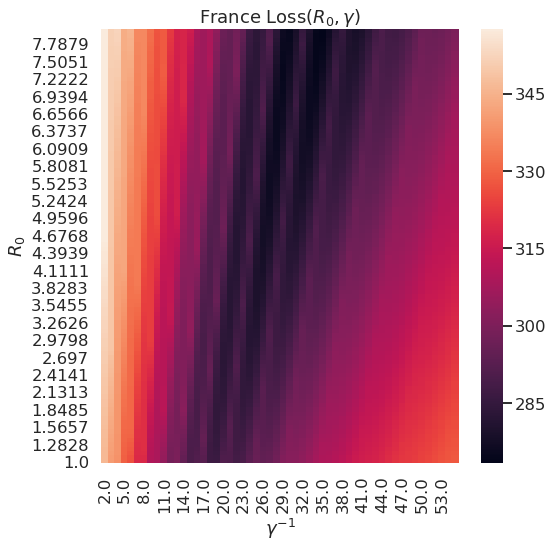

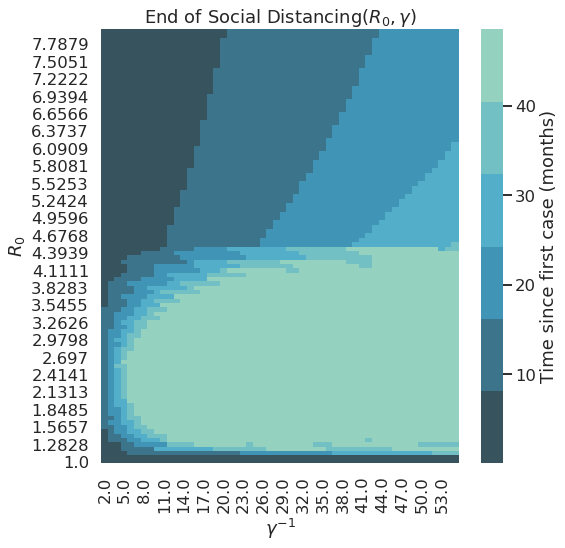

In [101]:
fig,ax = plt.subplots(figsize=(8,8))
fig,ax2 = plt.subplots(figsize=(8,8))
cmap = sns.color_palette("GnBu_d")

n_eff_str = r'$N_{eff}$'
res_df_hm = res_df.copy()
hm = res_df_hm.pivot(r0_str,gamma_str,'score')
sns.heatmap(hm,ax=ax)
if(NORM):
    ax.set_title(f'{country} Loss($R_0,\gamma$, {n_eff_str})')
else:
    ax.set_title(f'{country} Loss($R_0,\gamma$)')
ax.invert_yaxis()


hm = res_df_hm.pivot(r0_str,gamma_str,'endDist');hm = hm/30
sns.heatmap(hm,ax=ax2,cmap=cmap,
           cbar_kws={'label': 'Time since first case (months)'})
if(NORM):
    ax2.set_title(f'End of Social Distancing($R_0,\gamma$, {n_eff_str})')
else:
    ax2.set_title(f'End of Social Distancing($R_0,\gamma$)')
ax2.invert_yaxis()


### plot fit

5379 14 273.27813027624876 1 r_gamma_sims_nu46/cases_r0_8.0000_endDist_399.0_gamma_35.0000.csv
endDist:  399.0


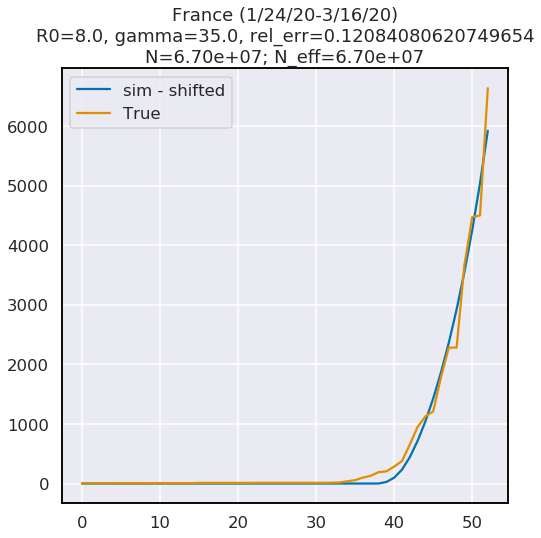

In [102]:
argmin = np.argmin(scores)
best_shift = shifts[argmin]
best_score = scores[argmin]
alpha = alphas[argmin]
best_file = sim_files[argmin]
print(argmin,shift,best_score,alpha,best_file)

# fig,ax = plt.subplots(figsize=(8,8))
file_name =   best_file #sim_files[693]


gamma = float(file_name.stem.split('_')[-1])
r0 = float(file_name.stem.split('_')[2])
endDist = float(file_name.stem.split('_')[4])
print('endDist: ', endDist)

c = pd.read_csv(file_name,index_col=0).values*(N/alpha)
d = c[::10] if(ds) else c
d = np.insert(d,0,np.zeros(n_zeros))
e = d[best_shift:best_shift+len(x)]
# ax.plot(d[:len(x)+n_zeros],label='sim')
# ax.plot(x,label='True')
# ax.legend()


fig,ax = plt.subplots(figsize=(8,8))
# x_hat = x*alpha
ax.plot(e,label='sim - shifted')
ax.plot(x,label='True')
ax.set_title(f'{country} ({sDate}-{eDate})\nR0={r0}, gamma={gamma}, rel_err={np.abs(e[-1]-x[-1])/e[-1]}\nN={N:.2e}; N_eff={N/alpha:.2e}')
ax.legend()


## CI 

In [103]:
chi = chi2.isf(q=1-0.95, df=2)
print(chi/2)
mle_score = res_df['score'].min()
ci_df = res_df[(res_df['score'] - mle_score)*2 <chi]
fullDisplay(ci_df.sort_values(['score']))


2.9957322735539895


,$R_0$,$\gamma^{-1}$,score,shift,alpha,endDist
5379,8.0000,35.0,273.278130,11.0,1.0,399.0
5325,7.9293,35.0,273.502735,11.0,1.0,402.0
5271,7.8586,35.0,273.755018,11.0,1.0,404.0
5108,7.6465,34.0,273.951072,11.0,1.0,400.0
5162,7.7172,34.0,273.966842,11.0,1.0,398.0
5054,7.5758,34.0,273.968398,11.0,1.0,403.0
5216,7.7879,34.0,274.015860,11.0,1.0,396.0
5000,7.5051,34.0,274.018544,11.0,1.0,405.0
5217,7.7879,35.0,274.033994,11.0,1.0,406.0
5270,7.8586,34.0,274.098153,11.0,1.0,393.0


# All plot 

## fit all 

In [168]:
res_dfs = []
chi = chi2.isf(q=1-0.95, df=1)



LOSS = 'LL' #'LL'

for region,files in zip(regions,files_list):
    print(region)
    x,country,output_file,N,sDate,eDate = data[region]
    
    scores = []
    shifts = []
    alphas = []
    res_mat = np.zeros((len(sim_files),6))
    NORM = False
    n_zeros = len(x)-5
    ds = False
    
    for i,sim_file in enumerate(sim_files):

        c = pd.read_csv(sim_file,index_col=0).values*N
        d = c[::10] if(ds) else c
        d = np.insert(d,0,np.zeros(n_zeros))
        
        gamma = float(sim_file.stem.split('_')[-1])
        r0 = float(sim_file.stem.split('_')[2])
        endDist = float(sim_file.stem.split('_')[4])
        score,shift,_,_,_,alpha = findBestShift(x,d,norm=NORM,loss=LOSS)
        res_mat[i,:]=[r0,gamma,score,shift,alpha,endDist]
        
#         print(score,shift,alpha,r0,gamma,endDist)
        scores.append(score)
        shifts.append(shift)
        alphas.append(alpha)
        

    res_df = pd.DataFrame(res_mat,columns=[r0_str,gamma_str,'score','shift','alpha','endDist'])
    res_dfs.append(res_df)
    
    if(LOSS=='LL'):
        mle_score = res_df['score'].min()
        ci_df = res_df[(res_df['score'] - mle_score)*2 <chi]
        ci_df.sort_values('score')
        display(ci_df.describe().loc[['min','max'],[R0_str,gamma_str]].T)



    

UK


,min,max
$R_0$,6.5859,8.0
$\gamma^{-1}$,26.0000,31.0


NY


,min,max
$R_0$,4.5354,8.0
$\gamma^{-1}$,2.0000,4.0


Sweden


,min,max
$R_0$,1.2828,1.5657
$\gamma^{-1}$,5.0000,9.0000


Spain


,min,max
$R_0$,5.596,8.0
$\gamma^{-1}$,10.000,11.0


France


,min,max
$R_0$,7.0808,8.0
$\gamma^{-1}$,29.0000,35.0


Germany


,min,max
$R_0$,6.9394,8.0
$\gamma^{-1}$,23.0000,28.0


Denmark


,min,max
$R_0$,1.0,8.0
$\gamma^{-1}$,2.0,5.0


In [ ]:
if(LOSS=='mse'): pickleDump('res_df_mse_loss.pkl',res_dfs)

## plot fits 

In [135]:
PP = True #normalize per population
regions = ['UK','NY','Sweden','Spain','France','Germany','Denmark']

files_list = [[5047,62,2772],# UK4.6
              [5294,2431], #NY4.6
              [384,54,219], # sw4.6
              [5085,2219,1841], #spain 4.6
              [5108,2454,611], # france 4.6
              [4940,1529,2282], # Germany 4.6
              [432,5349,3405] # Denmark
             ]
             
markers = ['v','X','H','d','+','*']
colors = ['r','y','m','orange','blue','pink']
DATE_ADD = 5

1/31/20 3/24/20


,$R_0$,$\gamma^{-1}$,score,shift,alpha,endDist
5047,7.5758,27.0,270.057702,12.0,1.0,327.0
62,1.0707,10.0,302.580181,9.0,1.0,44.0
2772,4.6061,20.0,278.311736,11.0,1.0,389.0


UK	7.5758	27.0	3/11/2020	01/2021
UK	1.0707	10.0	3/11/2020	04/2020
UK	4.6061	20.0	3/11/2020	04/2021
<a list of 8 Text xticklabel objects>
2020-03-01 2020-03-20


,$R_0$,$\gamma^{-1}$,score,shift,alpha,endDist
5294,7.9293,4.0,111.387716,5.0,1.0,75.0
2431,4.1818,3.0,118.571276,5.0,1.0,193.0


NY	7.9293	4.0	3/11/2020	05/2020
NY	4.1818	3.0	3/11/2020	09/2020
<a list of 8 Text xticklabel objects>
2/1/20 3/15/20


,$R_0$,$\gamma^{-1}$,score,shift,alpha,endDist
5085,7.6465,11.0,237.392121,7.0,1.0,152.0
2219,3.8990,7.0,240.281608,6.0,1.0,512.0
1841,3.4040,7.0,243.146480,6.0,1.0,915.0


Spain	7.6465	11.0	3/11/2020	08/2020
Spain	3.899	7.0	3/11/2020	08/2021
Spain	3.404	7.0	3/11/2020	09/2022
<a list of 8 Text xticklabel objects>
1/24/20 3/16/20


,$R_0$,$\gamma^{-1}$,score,shift,alpha,endDist
5108,7.6465,34.0,273.951072,11.0,1.0,400.0
2454,4.1818,26.0,278.573555,10.0,1.0,1072.0
611,1.7778,19.0,284.398134,9.0,1.0,1459.0


France	7.6465	34.0	3/11/2020	04/2021
France	4.1818	26.0	3/11/2020	02/2023
France	1.7778	19.0	3/11/2020	03/2024
<a list of 9 Text xticklabel objects>
1/27/20 3/16/20


,$R_0$,$\gamma^{-1}$,score,shift,alpha,endDist
4940,7.4343,28.0,266.002328,9.0,1.0,342.0
1529,2.9798,19.0,272.415710,8.0,1.0,1429.0
2282,3.9697,16.0,273.534811,7.0,1.0,874.0


Germany	7.4343	28.0	3/11/2020	02/2021
Germany	2.9798	19.0	3/11/2020	02/2024
Germany	3.9697	16.0	3/11/2020	08/2022
<a list of 8 Text xticklabel objects>
2/27/20 3/11/20


,$R_0$,$\gamma^{-1}$,score,shift,alpha,endDist
432,1.5657,2.0,41.089197,1.0,1.0,247.0
5349,8.0000,5.0,38.148417,2.0,1.0,84.0
3405,5.4545,5.0,40.448032,2.0,1.0,117.0


Denmark	1.5657	2.0	3/11/2020	11/2020
Denmark	8.0	5.0	3/11/2020	06/2020
Denmark	5.4545	5.0	3/11/2020	07/2020
<a list of 10 Text xticklabel objects>


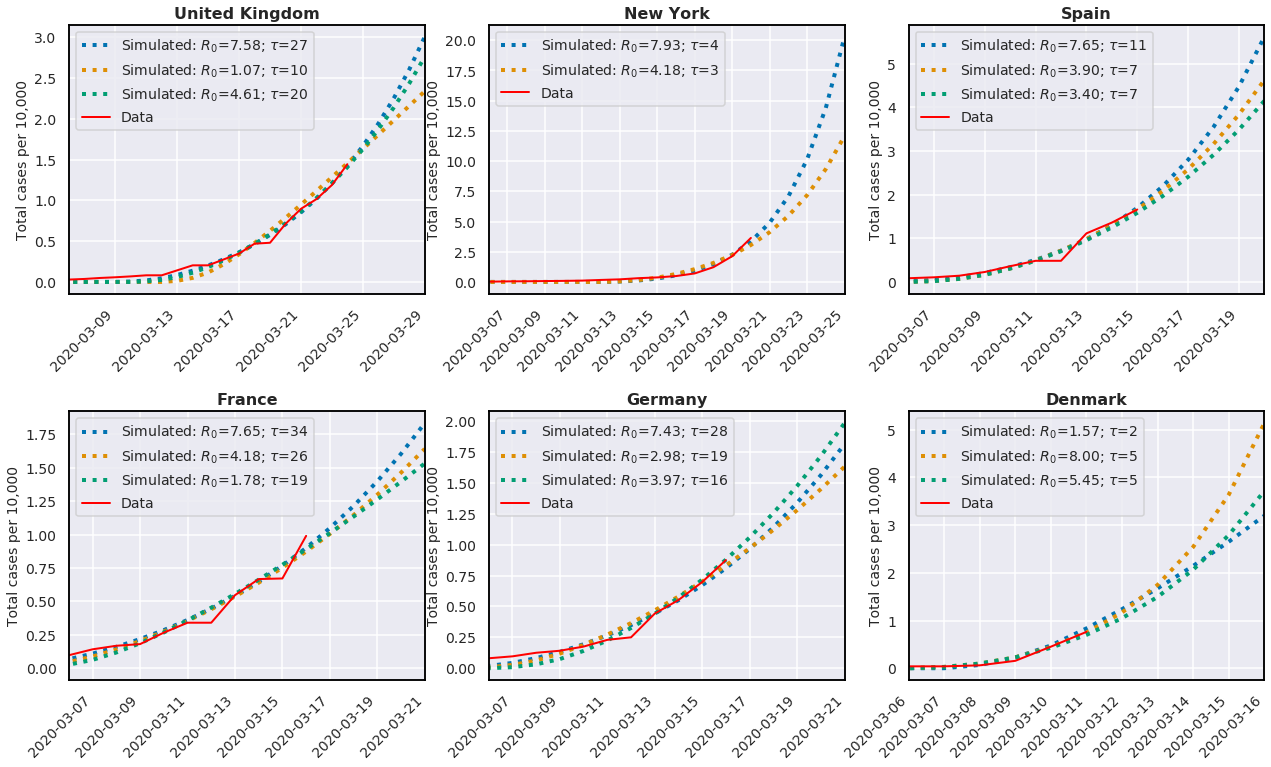

In [229]:
sim_date = '3/11/2020'
N_REGIONS = 6
W_KISSLER = False
exclude = ['']



regions_plot = [r for r in regions if r not in exclude]
res_dfs_plot = [res for res,r in zip(res_dfs,regions) if r not in exclude]
files_list_plot = [res for res,r in zip(files_list,regions) if r not in exclude]

fig,axes = plt.subplots(2,3,figsize=(18,11),sharex=False); axes = axes.ravel()


for region,files,ax,res_df_i in zip(regions_plot,files_list_plot,axes,res_dfs_plot):
    x,country,output_file,N,sDate,eDate = data[region]
    
    print(sDate,eDate)

    dates = pd.date_range(sDate,eDate,freq='D',)
    dates2 = pd.date_range(sDate,periods=len(dates)+DATE_ADD,freq='D')
    r0s = []
    gammas = []
    n_row = res_df_i[gamma_str].nunique()
    display(res_df_i.loc[files])
    n_zeros = len(x)-5






    for file_i in files:
        file_name = sim_files[file_i]

        gamma = float(file_name.stem.split('_')[-1])
        r0 = float(file_name.stem.split('_')[2])
        r0s.append(file_i//n_row)
        gammas.append(file_i%n_row)

        shift,alpha,endDist = res_df_i.loc[file_i][['shift','alpha','endDist']].values
        c = pd.read_csv(file_name,index_col=0).values*(N/alpha)
        d = c[::10] if(ds) else c
        d = np.insert(d,0,np.zeros(n_zeros))
        e = d[int(shift):int(shift)+len(x)+DATE_ADD]
#         print(region,r0,gamma,shift,alpha,endDist,file_i)


        sde = pd.date_range(sim_date,periods=endDist,freq='D')[-1].strftime("%m/%Y")
        print(region,r0,gamma,sim_date,sde,sep='\t')
        gamma_str = r'$\gamma^{-1}$'
        R0_str = r'$R_0$'
        if(PP):
            ax.plot(dates2,e/(N*1e-4),linestyle=':',label=f'Simulated: {R0_str}={r0:.2f}; {tau_str}={gamma:.0f}',lw=4)
        else:
            ax.plot(dates2,e,linestyle=':',label=f'Simulated: {R0_str}={r0:.2f}; {gamma_str}={gamma:.0f}',lw=4)



    # True vals  
    if(PP):
        ax.plot(dates,x/(N*1e-4),label='Data',color='r',lw=2)
    else:
        ax.plot(dates,x,label='Data',color='r',lw=2)
        
    ax.set_title(f'{country}', fontweight='bold',fontsize=16) #,fontsize=14
    if(PP):
        ax.set_ylabel('Total cases per 10,000',fontsize=14)
    else:
        ax.set_ylabel(f'Total cases',fontsize=14)
        
    ax.legend(loc='upper left',prop={'size': 14})
    print(ax.get_xticklabels())
    if(region=='Sweden'): ax.set_xticks(dates[::-7])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_xlim(('3/6/2020',dates2[-1]))
    ax.tick_params(labelsize=14)
    
# fig.subplots_adjust(bottom=0.2)   
plt.tight_layout()
fig.subplots_adjust(wspace=0.18)



## plot heat-map

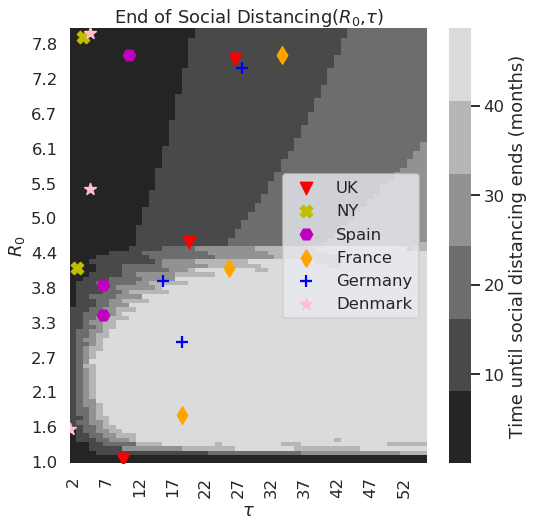

In [231]:
fig2,ax2 = plt.subplots(figsize=(8,8))
cmap = sns.color_palette("GnBu_d",)
cmap = sns.color_palette("gray")
output_dir = Path('/opt/genomics/Jupyter_Notebook/NadavRakocz/covid19/science')





#====================
# HEAT MAP
#====================
res_df_hm = res_df.copy()
res_df_hm.columns = [R0_str,tau_str,'score','shift','alpha','endDist']
hm = res_df_hm.pivot(r0_str,tau_str,'endDist');hm = hm/30
sns.heatmap(hm,ax=ax2,cmap=cmap,
            xticklabels=5, yticklabels=8,fmt='%.1f',
           cbar_kws={'label': 'Time until social distancing ends (months)'})
if(NORM):
    ax2.set_title(f'End of Social Distancing($R_0,\gamma$, {n_eff_str})')
else:
    ax2.set_title(f'End of Social Distancing($R_0$,{tau_str})')
ax2.invert_yaxis()

#======================
# Scatters
#======================

for region,files,marker,color in zip(regions_plot,files_list_plot,markers,colors):
    gammas = []
    r0s = []
    for file_i in files:
        file_name = sim_files[file_i]

        gamma = float(file_name.stem.split('_')[-1])
        r0 = float(file_name.stem.split('_')[2])
        r0s.append(file_i//n_row)
        gammas.append(file_i%n_row)


    ax2.scatter(gammas,r0s,color=color,marker=marker,label=region,s=150)









#kissler
if(W_KISSLER):
    k_gammas = [4,4]
    k_rs = [16,24]
    ax2.scatter(k_gammas,k_rs,color='darkgreen',marker='^',label='Kissler et al.',s=150)
    ax2.plot(k_gammas,k_rs,color='darkgreen',lw=2)
    # ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax2.legend(loc='center right')
yticks=ax2.get_yticklabels()
ytickslabels = [f'{float(i.get_text()):.1f}' for i in yticks]
ax2.set_yticklabels(ytickslabels)

xticks=ax2.get_xticklabels()
xtickslabels = [f'{float(i.get_text()):.0f}' for i in xticks]
ax2.set_xticklabels(xtickslabels,rotation=90)
# plt.setp(ax2.get_xticklabels(), rotation=90, ha="right")

plt.savefig(str(output_dir/'figure2.png'))